<a href="https://colab.research.google.com/github/giahuy1310/bookrecommendation/blob/Ghuy/Copy_of_bigdata_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data


Install Spark

In [1]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark properly
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# Check if file is downloaded
!ls -l spark-3.5.0-bin-hadoop3.tgz

# Extract the downloaded file
!tar -xvzf spark-3.5.0-bin-hadoop3.tgz

# Install findspark
!pip install -q findspark


-rw-r--r-- 1 root root 400395283 Sep  9  2023 spark-3.5.0-bin-hadoop3.tgz
spark-3.5.0-bin-hadoop3/
spark-3.5.0-bin-hadoop3/kubernetes/
spark-3.5.0-bin-hadoop3/kubernetes/tests/
spark-3.5.0-bin-hadoop3/kubernetes/tests/pyfiles.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/autoscale.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/python_executable_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/worker_memory_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/py_container_checks.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning_cleanup.py
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/decom.sh
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.5.0-bin-hadoop3/ku

Set up Spark Environment

In [2]:
# Set up Spark environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# Print SPARK_HOME to verify the path
print(f"SPARK_HOME: {os.environ['SPARK_HOME']}")

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

SPARK_HOME: /content/spark-3.5.0-bin-hadoop3


In [3]:
import pandas as pd

Load data

In [4]:
# Import data from GitHub using wget
!wget -O data.zip 'https://github.com/giahuy1310/bookrecommendation/raw/main/BookDataset.zip'
!unzip data.zip

# Load data into Spark DataFrame
users_df = spark.read.csv('Users.csv', header=True, inferSchema=True)
books_df = spark.read.csv('Books.csv', header = True, inferSchema=True)
ratings_df = spark.read.csv('Ratings.csv', header=True, inferSchema=True)



--2025-04-28 07:52:54--  https://github.com/giahuy1310/bookrecommendation/raw/main/BookDataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/giahuy1310/bookrecommendation/main/BookDataset.zip [following]
--2025-04-28 07:52:54--  https://raw.githubusercontent.com/giahuy1310/bookrecommendation/main/BookDataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25500788 (24M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  24.32M  --.-KB/s    in 0.1s    

2025-04-28 07:52:55 (215 MB/s) - ‘data.zip’ saved [25500788/25500788]

Archive:  data.zip
replace

# Làm việc với 3 bảng

Data cleaning and preprocessing

In [5]:
# Clean Users DataFrame
users_df = users_df.dropna(subset=['Location', 'Age'])
users_df = users_df.filter((users_df['Age'] >= 18) & (users_df['Age'] <= 50))
users_df = users_df.drop('Location')

# Clean Books DataFrame
books_df = books_df.dropDuplicates(['ISBN'])

# Clean Ratings DataFrame
ratings_df = ratings_df.filter(ratings_df['Book-Rating'] != 0)

Merging DataFrames

In [6]:
merged_df = ratings_df.join(books_df, 'ISBN', 'left') \
                      .join(users_df, 'User-ID', 'left') \
                      .dropna()

In [7]:
# Drop the 'Location' column
if 'Location' in users_df.columns:
    users_df = users_df.drop('Location', axis=1)
    print("'Location' column dropped.")
else:
    print("'Location' column not found.")
users_df

'Location' column not found.


DataFrame[User-ID: int, Age: string]

##Book table

ISBN là khóa chính xác định duy nhất từng cuốn sách. Việc có ISBN trùng lặp sẽ chỉ ra sự không nhất quán trong dữ liệu, trong đó cùng một cuốn sách có thể được liệt kê nhiều lần với thông tin có khả năng khác nhau.
Tính toàn vẹn dữ liệu: Việc loại bỏ các mục trùng lặp đảm bảo rằng mỗi cuốn sách chỉ được biểu diễn một lần trong DataFrame, dẫn đến phân tích chính xác hơn và ngăn ngừa các sự cố khi hợp nhất với các DataFrame khác (như Xếp hạng).

## EDA

In [8]:
import pandas as pd
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for easier visualization
users_pd = users_df.toPandas()
books_pd = books_df.toPandas()
ratings_pd = ratings_df.toPandas()
merged_pd = merged_df.toPandas()

Users DataFrame Stats:
             User-ID
count  129777.000000
mean   139602.357089
std     80563.815372
min         2.000000
25%     70143.000000
50%    139799.000000
75%    209351.000000
max    278855.000000
0         18.0
1         26.0
2         26.0
3         25.0
4         19.0
          ... 
129772    23.0
129773    23.0
129774    33.0
129775    32.0
129776    50.0
Name: Age, Length: 129777, dtype: object


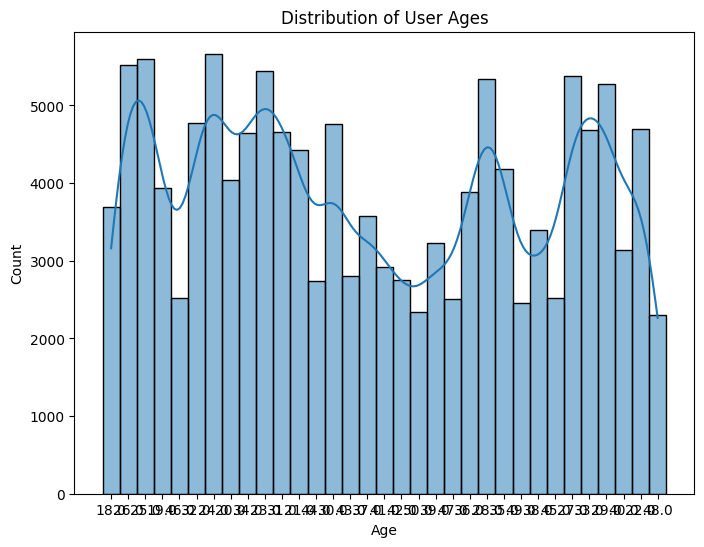

In [9]:
# Data Exploration: Users
print("Users DataFrame Stats:")
print(users_pd.describe())
print(users_pd['Age'])

plt.figure(figsize=(8, 6))
sns.histplot(users_pd['Age'], bins='auto', kde=True)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


Books DataFrame Stats:
              ISBN      Book-Title      Book-Author Year-Of-Publication  \
count       271360          271360           271359              271360   
unique      271360          242134           102052                 169   
top     B00013AFZQ  Selected Poems  Agatha Christie                2002   
freq             1              27              631               17624   

        Publisher             Image-URL-S  \
count      271358                  271360   
unique      16843                  271038   
top     Harlequin  Advance Publishers LLC   
freq         7533                       3   

                                              Image-URL-M  \
count                                              271360   
unique                                             271044   
top     http://images.amazon.com/images/P/156414075X.0...   
freq                                                    2   

                                              Image-URL-L  
count   

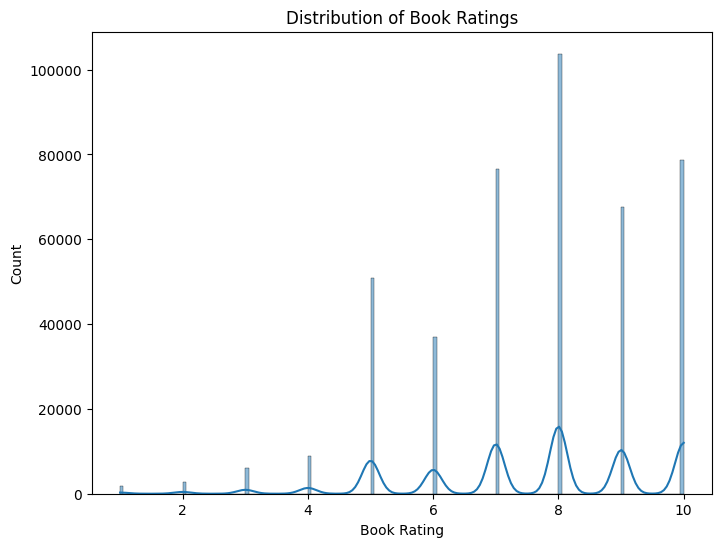


Merged DataFrame Stats:
             User-ID    Book-Rating
count  216826.000000  216826.000000
mean   138592.436627       7.707447
std     79606.128962       1.822001
min        51.000000       1.000000
25%     70065.000000       7.000000
50%    137777.500000       8.000000
75%    207339.000000       9.000000
max    278852.000000      10.000000


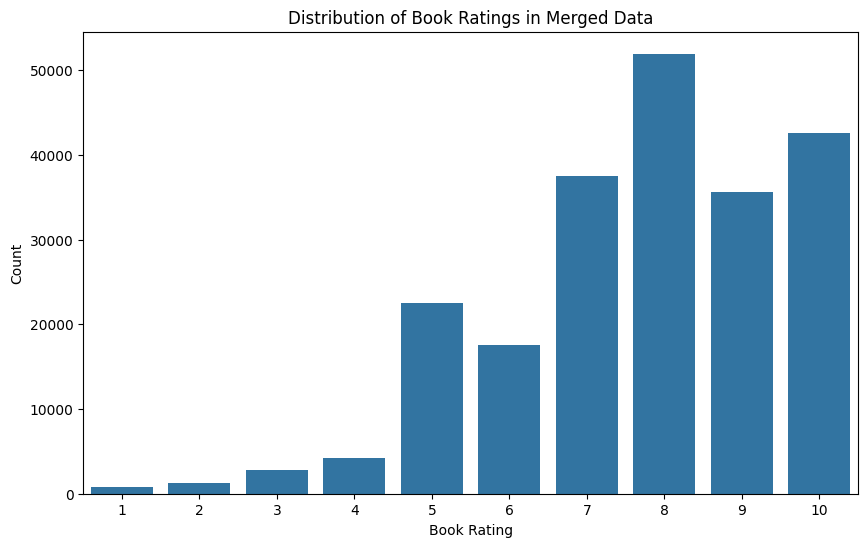


Top 10 Most Rated Books:
 Book-Title
The Lovely Bones: A Novel                           384
Wild Animus                                         353
The Da Vinci Code                                   288
Bridget Jones's Diary                               245
The Nanny Diaries: A Novel                          220
The Secret Life of Bees                             214
Life of Pi                                          205
Angels &amp; Demons                                 203
Harry Potter and the Chamber of Secrets (Book 2)    202
The Red Tent (Bestselling Backlist)                 189
Name: Book-Rating, dtype: int64


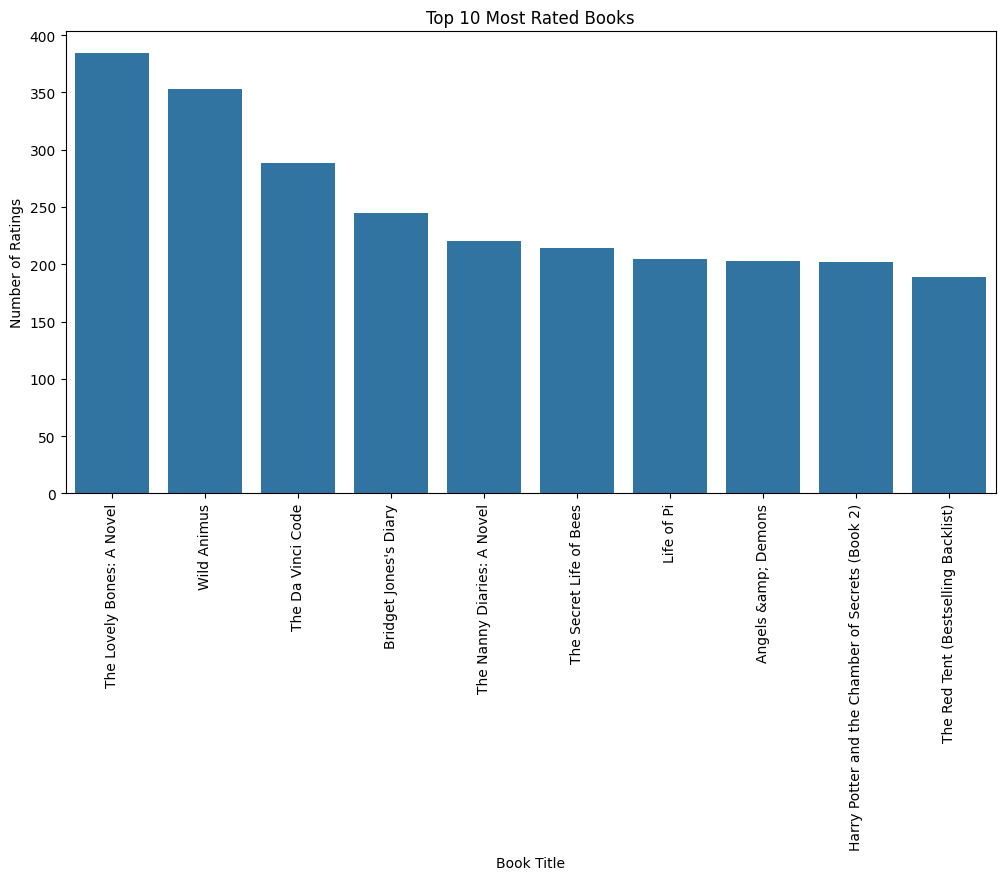

In [10]:



# Data Exploration: Books
print("\nBooks DataFrame Stats:")
print(books_pd.describe())


# Data Exploration: Ratings
print("\nRatings DataFrame Stats:")
print(ratings_pd.describe())

plt.figure(figsize=(8, 6))
sns.histplot(ratings_pd['Book-Rating'], kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

# Explore the merged DataFrame
print("\nMerged DataFrame Stats:")
print(merged_pd.describe())

plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=merged_pd)
plt.title('Distribution of Book Ratings in Merged Data')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

# Example: Top 10 most rated books
top_rated_books = merged_pd.groupby('Book-Title')['Book-Rating'].count().sort_values(ascending=False).head(10)
print("\nTop 10 Most Rated Books:\n", top_rated_books)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_rated_books.index, y=top_rated_books.values)
plt.title('Top 10 Most Rated Books')
plt.xlabel('Book Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()